In [9]:
#データの読み込み
import numpy as np
import pandas as pd 
from config import Config

import warnings
warnings.filterwarnings('ignore')

## 目次
1. [データの抽出](#a)
2. [データ意味の確認](#b)
3. [データ品質の確認](#c)
4. [データ処理方法の考察](#d)
5. [特徴作成](#e)

[練習課題](#f)

<head>
    <b><a id="a">1.データ抽出<a></b>
</head>
<body>
    <p><b>目的：サンプル走行データの読み込み。pandasデータフレームにする</b></p>
    <hr />
    <p></p>
</body>

In [10]:
#dataの保存先絶対パスを取得
opt = Config() # 設定ファイルを読みこみ
data_path_aions = getattr(opt, "data_path_aions")
data_path_gs3 = getattr(opt, "data_path_gs3")
data_path_gs4 = getattr(opt, "data_path_gs4")

In [11]:
#走行データ読み込み。データフレームにする
def readtable(abspath, headerpath=opt.header_path_gs3):
    
    """
    path:データの保存先の絶対パス
    """
    data = pd.read_table(abspath + "/all.txt", header=None)
    
    if headerpath:
        with open(abspath +  headerpath) as f:
            header = f.read()
            header = [i.strip() for i in header.split(",")]
        data.columns = header 
    return data 

In [12]:
#gs3の車データを読み込み
gs3_data = readtable(data_path_gs3) 

<head>
<t><b><a id="b">2.データ意味の確認</a></b></t> 
</head>
<body>
<p>gs3_data</p>
    <ol>
        <li>VIN: 車台番号</li>
        <li>timestamp: 時刻</li>
        <li>bos_vehspd:速度</li>
        <li>bcs_vehspdvd:速度有効かどうか</li>
        <li>bcs_actvehlaltrlaccel:右左加速度</li>
        <li>bcs_ActVehLongAccel:上下加速度</li>
        <li>sas_SteeringAngleSpd</li>
        <li>TEL_LatitudeDeg:度</li>
        <li>TEL_LatitudeMin:分</li>
        <li>TEL_LatitudeSec:秒</li>
        <li>TEL_LongitudeDeg:度</li>
        <li>TEL_LongitudeMin:分</li>
        <li>TEL_LongitudeSec:秒</li>
        <li>ICM_TotalOdometer:累計運転距離</li>
        <li>BCM_KeySt:エンジンON＝OFF </li>
    </ol>
</body>
<hr />

<head>
    <b><a id="c">3.データ品質の確認</a></b>
    <base href="C:\Users\dso-s.gao\Desktop￥" > 
</head>
<body>
    <p>
        <b>目的：サンプルデータの欠損率、異常値を確認、欠損処理、異常値処理を行う</b>
        <br>
        <a href="https://confluence.adi-datasol.com/pages/viewpage.action?pageId=2951175">参考)タフツの前処理方法</a>
        <br>
    <p>
        <b>データの全体的な特徴を把握するために以下の項目を集計する.</b>
        <br>1.VINの数
        <br><del>2.車種ごとのVINの数</del> => gs3一車種のため
        <br>3.レコードの重複
        <br>4.VINとデータの取得時刻（data_acq_time）の組でレコードが一意に決まるか
        <br>5.カラムごとの欠損状況
        <br>6.カラムごとのヒストグラム
    </p>
 <hr/>
    <p></p>
</body>

In [13]:
#１．VINの数を確認
print("VINの数", gs3_data["vin"].nunique())

VINの数 10


In [14]:
#3.レコードの重複 
#4.VINとデータの取得時刻（data_acq_time）の組でレコードが一意に決まるか
gs3_data[gs3_data.groupby(["vin", "timestamp"], as_index=False)["bcs_vehspd"].count()["bcs_vehspd"] >= 2]

,vin,timestamp,bcs_vehspd,bcs_vehspdvd,bcs_actvehlaltrlaccel,bcs_ActVehLongAccel,sas_SteeringAngleSpd,TEL_LatitudeDeg,TEL_LatitudeMin,TEL_LatitudeSec,TEL_LongitudeDeg,TEL_LongitudeMin,TEL_LongitudeSec,ICM_TotalOdometer,BCM_KeySt


In [15]:
#5.カラムごとの欠損状況
print("欠損データの数")
print(gs3_data.isnull().sum()) # => 欠損データの数
print("========================================")
print("欠損率")
print(gs3_data.isnull().sum() / len(gs3_data))

欠損データの数
vin                            0
timestamp                      0
bcs_vehspd                    60
bcs_vehspdvd             1607049
bcs_actvehlaltrlaccel         60
bcs_ActVehLongAccel           60
sas_SteeringAngleSpd          60
TEL_LatitudeDeg               60
TEL_LatitudeMin               60
TEL_LatitudeSec               60
TEL_LongitudeDeg              60
TEL_LongitudeMin              60
TEL_LongitudeSec              60
ICM_TotalOdometer             60
BCM_KeySt                     60
dtype: int64
欠損率
vin                      0.000000
timestamp                0.000000
bcs_vehspd               0.000037
bcs_vehspdvd             0.982771
bcs_actvehlaltrlaccel    0.000037
bcs_ActVehLongAccel      0.000037
sas_SteeringAngleSpd     0.000037
TEL_LatitudeDeg          0.000037
TEL_LatitudeMin          0.000037
TEL_LatitudeSec          0.000037
TEL_LongitudeDeg         0.000037
TEL_LongitudeMin         0.000037
TEL_LongitudeSec         0.000037
ICM_TotalOdometer        0.000037
BCM_

In [16]:
#6.カラムごとのヒストグラム
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 
import visdom

#カラムごとのヒストグラムをplotする
def plotdist(env, column, data):
    vis = visdom.Visdom(env=env)
    return vis.histogram(
                data[data[column].notnull()][column], 
                win= column + "pane_name", 
                opts={
                    "numbins":20, 
                    "title": column, 
                    "ylabel":"Count"
                    })

In [17]:
#集計図をlocalhost:8097で確認
for column in gs3_data.columns:
    
    if column != "vin": 
        plotdist("gs3_data_2", column=column, data=gs3_data)
    
print("集計図はここで確認{}".format("http://localhost:8097/"))

Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...
Setting up a new session...


集計図はここで確認http://localhost:8097/


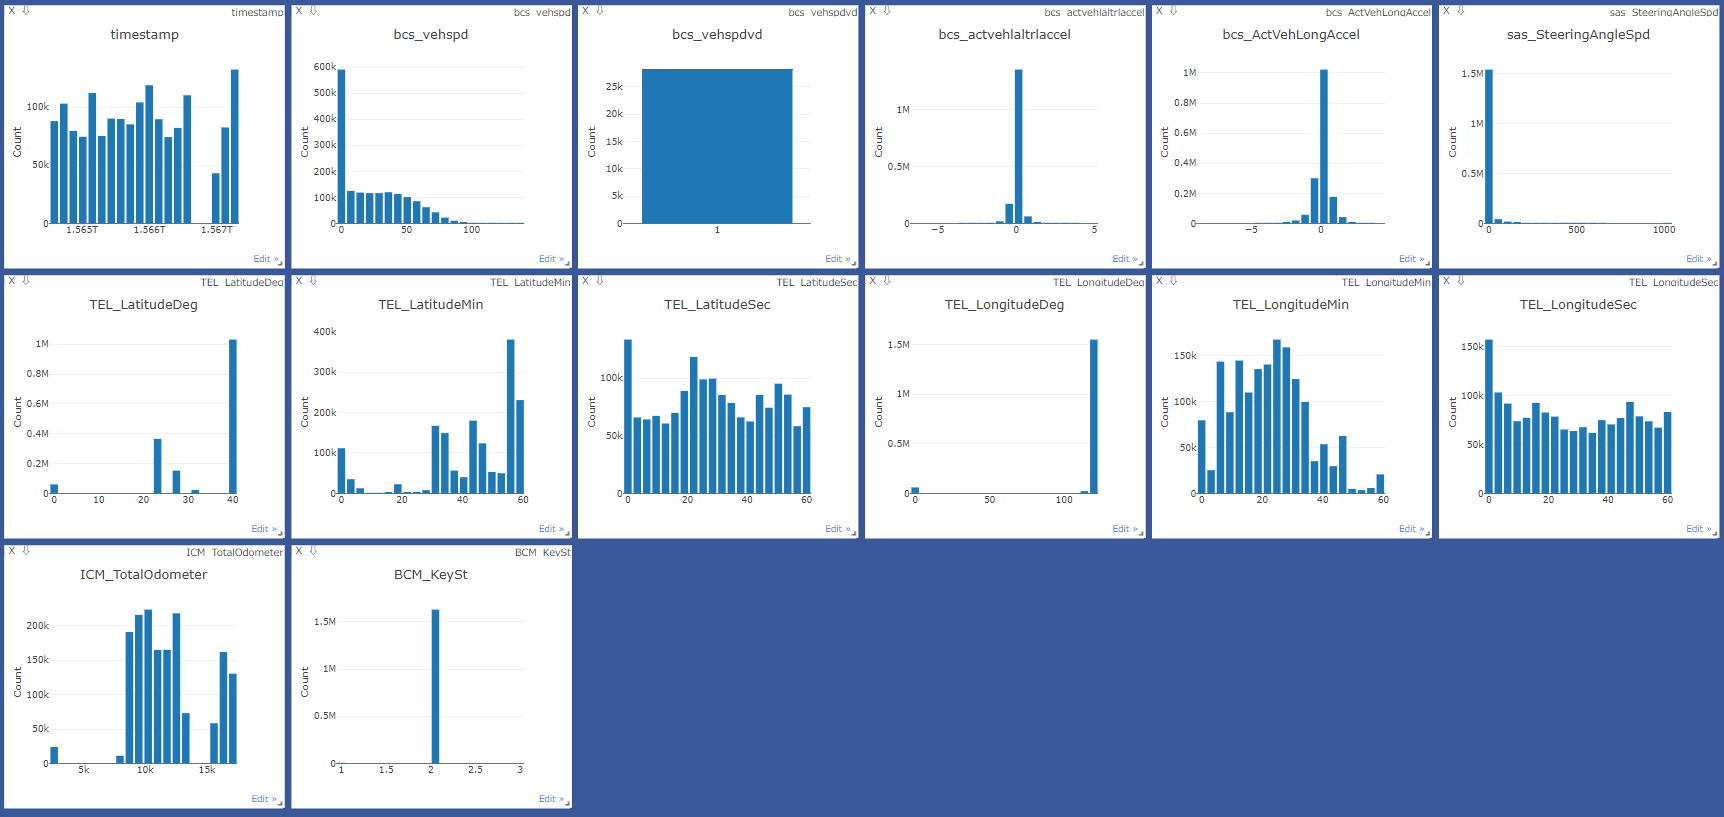

In [18]:
#集計図
from PIL import Image
Image.open("/home/gaosi/syukei.PNG")

In [19]:
#「vin名、timestamp」でデータをsortします。 
gs3_data.sort_values(by=["vin" ,"timestamp"], ascending=True, inplace=True)

#indexを振りなおす
gs3_data.reset_index(inplace=True)

#index列を削除
gs3_data.drop(["index"], axis=1, inplace=True)

In [20]:
#timestampを中国当地時間に変換
#Unix エポック タイムスタンプ形式のようです
import datetime 
#from datetime import fromtimestamp
from pytz import timezone

#UTX時間を生成
gs3_data["UTC_TIME"] = gs3_data["timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(int(x / 1000)))

#change UTC time to local time (Beijing)
#gs3_data["UTC_TIME"] = gs3_data["UTC_TIME"] + datetime.timedelta(hours=8)

In [21]:
#経度をＤＥＧ形式に変更
gs3_data["lon_deg"] = \
    gs3_data["TEL_LongitudeDeg"] + gs3_data["TEL_LongitudeMin"]/60 + gs3_data["TEL_LongitudeSec"]/3600

#緯度をＤＥＧ形式に変更
gs3_data["lat_deg"] = \
    gs3_data["TEL_LatitudeDeg"] + gs3_data["TEL_LatitudeMin"]/60 + gs3_data["TEL_LatitudeSec"]/3600

In [22]:
#緯度と経度をtuple形式にします。
gs3_data["lat_long"] = \
    gs3_data[["lat_deg", "lon_deg"]].apply(lambda x :(x["lat_deg"],x["lon_deg"]), axis=1)

<head>
    <style type="text/css">
        p{color:green;text-align:center}
    </style>
    <b><a id="d">4.データ処理方法の考察</a></b>
</head>
<body>
    <p>
         １．欠損値のバターンの考察<a href="http://sinhrks.hatenablog.com/entry/2016/02/01/080859#%E6%AC%A0%E6%90%8D%E3%83%91%E3%82%BF%E3%83%BC%E3%83%B3%E3%81%AE%E5%8F%AF%E8%A6%96%E5%8C%96">(参考)欠損パターン</a><br/>２．欠損値処理 <br/>３．異常値処理
    </p>
<body>

In [23]:
#１．欠損値のバターンの考察
#一見ランダムに欠損しているように目えます。
gs3_data[gs3_data["TEL_LongitudeDeg"].isnull()].groupby(["vin", gs3_data["UTC_TIME"].dt.day]).count()["timestamp"]

vin                UTC_TIME
LMWHP1S20J1000691  9           2
                   22          2
                   23          1
LMWHP1S20J1000707  5           1
                   9           1
                   31          1
LMWHP1S20J1000710  19          1
LMWHP1S20J1000898  2           2
                   6           1
                   10          1
                   13          2
                   29          2
LMWHP1S20J1000903  2           1
                   5           1
                   7           1
                   20          1
                   31          1
LMWHP1S20J1000917  12          1
                   13          1
                   19          1
                   20          1
                   23          1
LMWHP1S20J1000920  7           1
                   16          1
                   31          1
LMWHP1S20J1001047  2           1
                   6           1
                   9           1
                   21          1
LMWHP1S20J10010

In [24]:
#２．欠損処理については、欠損したデータを削除
gs3_data = gs3_data[gs3_data["TEL_LatitudeDeg"].notnull()]
gs3_data.reset_index(inplace=True)

#### 3.<b>異常値処理（１）</b> 
＝＞分布図から以下の課題を確認できる <br /> 
1. timestamp => 間が開いている。間隔が正しいかどうかを確認
2. bsc_vehspd => 速度部分tailのが正しいかどうかを確認
3. TEL_LongitudeDeg、TEL_LatitudeDegが0ゼロのデータがあるので、どう処理すべきかの確認

In [25]:
#1　timestamp => 間隔が正しいかどうかを確認
gs3_data["lag_1"] = \
    gs3_data.groupby("vin")["timestamp"].transform(lambda x:x.shift(1))

#時間差計算(T1 -T0)
gs3_data["time_diff"] = (gs3_data["timestamp"] - gs3_data["lag_1"])/1000

#時間差集計
gs3_data["time_diff"].value_counts().sort_index().cumsum()/len(gs3_data) 

# => 対応方針：レコードの時間間隔が１、２秒のデータがほとんど99.39%のため、
#間隔が3秒以上のレコードはデバイスの通信不良および別のトリップとみなして計算対象外のフラグを立てる
gs3_data["error_flag"] = gs3_data["time_diff"].apply(lambda x : 1 if x >= 3 else 0)

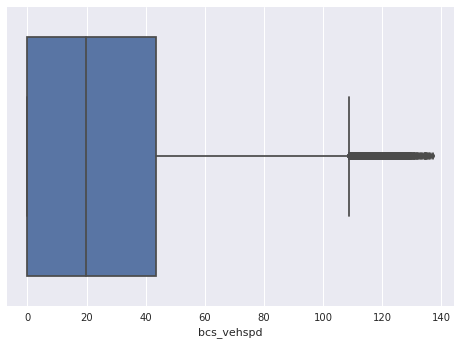

In [26]:
#２．bsc_vehspd => 速度部分tailのが正しいかどうかを確認
sns.boxplot(gs3_data["bcs_vehspd"])

#対応方針：速度最大値が１４０㎞/ｈぐらい。常識範囲内と確認。異常値として処理せず

In [27]:
#３．TEL_LongitudeDeg、TEL_LatitudeDegが0ゼロのデータがあるので、どう処理すべきかの確認
#対応：特徴抽出に影響がないため削除せずに保留
gs3_data.query("TEL_LatitudeDeg == 0")

,index,vin,timestamp,bcs_vehspd,bcs_vehspdvd,bcs_actvehlaltrlaccel,bcs_ActVehLongAccel,sas_SteeringAngleSpd,TEL_LatitudeDeg,TEL_LatitudeMin,...,TEL_LongitudeSec,ICM_TotalOdometer,BCM_KeySt,UTC_TIME,lon_deg,lat_deg,lat_long,lag_1,time_diff,error_flag
0,0,LMWHP1S20J1000691,1564627803000,18.33750,NaN,-0.271386,1.898753,16.0,0.0,0.0,...,0.0,15105.0,2.0,2019-08-01 11:50:03,0.0,0.0,"(0.0, 0.0)",NaN,NaN,0
1,1,LMWHP1S20J1000691,1564627804000,18.61875,NaN,0.325403,1.654613,0.0,0.0,0.0,...,0.0,15105.0,2.0,2019-08-01 11:50:04,0.0,0.0,"(0.0, 0.0)",1.564628e+12,1.0,0
2,2,LMWHP1S20J1000691,1564627805000,19.40625,NaN,-0.542653,1.546106,8.0,0.0,0.0,...,0.0,15105.0,2.0,2019-08-01 11:50:05,0.0,0.0,"(0.0, 0.0)",1.564628e+12,1.0,0
3,3,LMWHP1S20J1000691,1564627806000,19.23750,NaN,0.135516,1.057825,0.0,0.0,0.0,...,0.0,15105.0,2.0,2019-08-01 11:50:06,0.0,0.0,"(0.0, 0.0)",1.564628e+12,1.0,0
4,4,LMWHP1S20J1000691,1564627807000,17.77500,NaN,0.406783,0.650924,20.0,0.0,0.0,...,0.0,15105.0,2.0,2019-08-01 11:50:07,0.0,0.0,"(0.0, 0.0)",1.564628e+12,1.0,0
5,5,LMWHP1S20J1000691,1564627808000,15.24375,NaN,-0.000118,0.650924,16.0,0.0,0.0,...,0.0,15105.0,2.0,2019-08-01 11:50:08,0.0,0.0,"(0.0, 0.0)",1.564628e+12,1.0,0
6,6,LMWHP1S20J1000691,1564627809000,12.26250,NaN,-0.000118,0.027009,24.0,0.0,0.0,...,0.0,15105.0,2.0,2019-08-01 11:50:09,0.0,0.0,"(0.0, 0.0)",1.564628e+12,1.0,0
7,7,LMWHP1S20J1000691,1564627810000,9.61875,NaN,0.027009,-1.410708,4.0,0.0,0.0,...,0.0,15105.0,2.0,2019-08-01 11:50:10,0.0,0.0,"(0.0, 0.0)",1.564628e+12,1.0,0
8,8,LMWHP1S20J1000691,1564627811000,7.76250,NaN,0.271149,-0.217132,232.0,0.0,0.0,...,0.0,15105.0,2.0,2019-08-01 11:50:11,0.0,0.0,"(0.0, 0.0)",1.564628e+12,1.0,0
9,9,LMWHP1S20J1000691,1564627812000,8.83125,NaN,1.003571,-0.461273,208.0,0.0,0.0,...,0.0,15105.0,2.0,2019-08-01 11:50:12,0.0,0.0,"(0.0, 0.0)",1.564628e+12,1.0,0


### <a id="e">5. 特徴作成</a>
<hr />
1. gs3_dataの速度"bcs_vehspd"項から、加速度を算出 <br />
2. 同じイベントと認める秒数

In [28]:
# 1.gs3_dataの速度"bcs_vehspd"項から、加速度を算出
#ＶＩＮ番号単位で１秒前の速度の情報を取り入れる
gs3_data["lag_vehspd"] = \
    gs3_data.groupby("vin")["bcs_vehspd"].transform(lambda x:x.shift(1))
    
#速度差(V1 - V0)
gs3_data["speed_diff"] = gs3_data["bcs_vehspd"] - gs3_data["lag_vehspd"]

In [29]:
#加速度の計算　(V1 -V0)/t1 -t0 
gs3_data["accel"] = (gs3_data["speed_diff"] / 3.6) / gs3_data["time_diff"] 

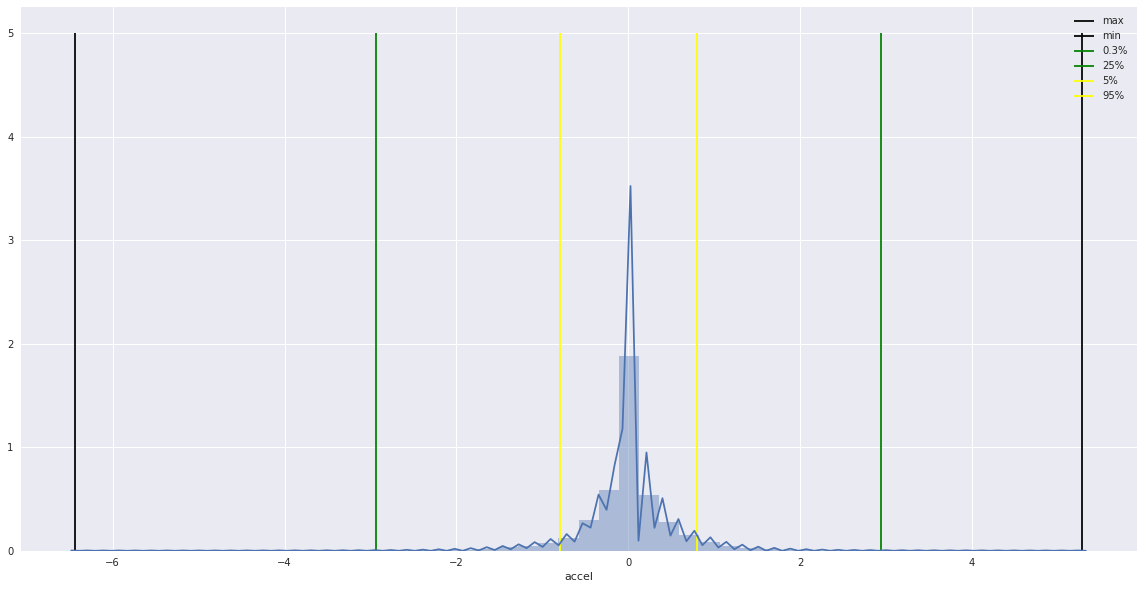

In [47]:
#加速度の分布を確認
plt.figure(figsize=(20, 10))
plt.vlines(x=gs3_data["accel"].max(), ymax=5, ymin=0, label="max")
plt.vlines(x=gs3_data["accel"].min(), ymax=5, ymin=0, label="min")

plt.vlines(x=opt.therhold_accl ,ymax=5, ymin=0, colors="green", label="0.3%")
plt.vlines(x=-opt.therhold_accl ,ymax=5, ymin=0, colors="green", label="25%")

plt.vlines(x=gs3_data["accel"].quantile(.05) ,ymax=5, ymin=0, colors="yellow", label="5%")
plt.vlines(x=gs3_data["accel"].quantile(.95), ymax=5, ymin=0, colors="yellow", label="95%")

plt.legend()
sns.distplot(gs3_data.query("accel==accel & error_flag != 1")["accel"])

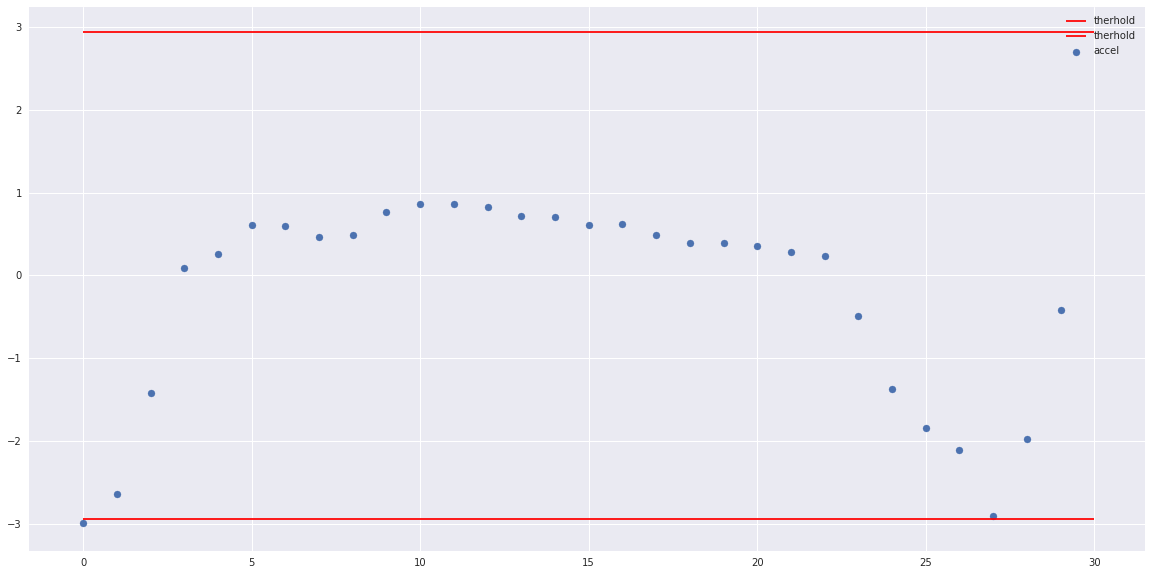

In [31]:
#イベント超過のバターンの確認
for index in gs3_data["accel"].index:
    acc = gs3_data["accel"][index]
    if abs(acc) >= opt.therhold_accl:
        plt.figure(figsize=(20 ,10))
        plt.hlines(y=opt.therhold_accl, xmin=0, xmax=30, colors="red", label="therhold")
        plt.hlines(y=-opt.therhold_accl, xmin=0, xmax=30, colors="red", label="therhold")
        plt.scatter(x=range(0, 30), y=gs3_data["accel"][index:index+30], label="accel")
        plt.legend()
        break

In [34]:
#イベント連続回数確認
con_list = []
count = 0
index = 0 

for i in range(len(gs3_data["accel"])):

    index = index + count
    acc = gs3_data["accel"][index]
    
    if abs(acc) >= opt.therhold_accl:
        
        count = 1 
        while True:
            
            acc_1 = gs3_data["accel"][index + count]
            
            if acc_1 >= opt.therhold_accl:
                count += 1
            else:
                break
        
        #print(count, index) 
        con_list.append((count, index))
        
    else:
        count += 1
    
    if index > len(gs3_data["accel"]):
        break

KeyError: 1635336

In [ ]:
#イベント超過のバターンの確認 => 急加速と急減速両方存在すると確認
index = 193
plt.figure(figsize=(20 ,10))
plt.hlines(y=opt.therhold_accl, xmin=0, xmax=30, colors="red", label="therhold")
plt.hlines(y=-opt.therhold_accl, xmin=0, xmax=30, colors="red", label="therhold")
plt.scatter(x=range(0, 30), y=gs3_data["accel"][index:index+30], label="accel")
plt.legend()

ZeroDivisionError: float division by zero

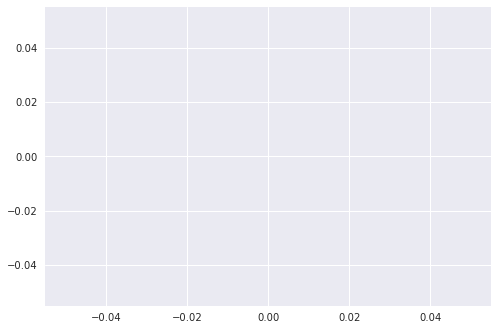

In [38]:
#イベント連続回数
count_list = [i[0] for i in con_list]
sns.distplot(count_list, kde=False)

#5レコードいないで終わる回数
(np.array(count_list) <= 10).sum()/len(con_list)

In [39]:
#イベント連続回数確認
con_break_list = []
count = 0
index = 0 

for i in range(len(gs3_data["accel"])):

    index = index + count
    acc = gs3_data["accel"][index]
    
    if abs(acc) >= opt.therhold_accl:
        
        count = 1 
        while True:
            
            acc_1 = gs3_data["accel"][index + count]
            
            if acc_1 <= -opt.therhold_accl:
                count += 1
            else:
                break
        
        #print(count, index) 
        con_break_list.append((count, index))
        
    else:
        count += 1
    
    if index > len(gs3_data["accel"]):
        break

KeyError: 1635336

ZeroDivisionError: float division by zero

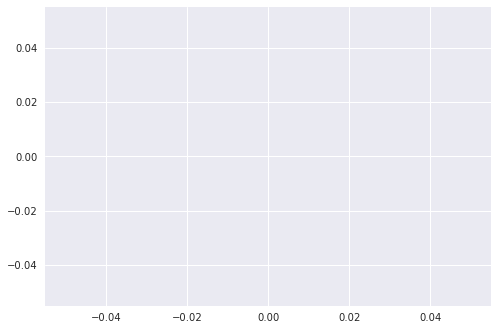

In [40]:
#イベント連続回数
count_list = [i[0] for i in con_break_list]
sns.distplot(count_list, kde=False)

#5レコードいないで終わる回数
(np.array(count_list) <= 5).sum()/len(con_break_list)

In [41]:
def bttherhold(index, accel, ctype="harsh_break"):
    
    if ctype == "harsh_break":
        
        if accel <= -opt.therhold_accl:
            next_index = index + opt.skip_step + 1
            return 1, next_index         
        else:
            next_index = index + 1
            return 0, next_index
    
    elif ctype == "harsh_accel":
        if accel >= opt.therhold_accl:
            next_index =index + opt.skip_step + 1
            return 1, next_index         
        else:
            next_index =index + 1
            return 0, next_index
        
    else:
        raise ValueError("you need select a ctype between harsh_break or harsh_accel")

In [42]:
def ifneedskip(index, time_diff):
    if time_diff > opt.time_diff :
        new_start_index = index + 1 
        return True, new_start_index
    
    else:
        return False, None 

In [43]:
# = > 連続イベント　=＞　５秒以内で同じイベントが発生してもカウントしないと決める
class GetHarshFeature(object):
    
    
    def __init__(self, index, df, ctype_ = "harsh_accel"):
        self.index = index
        self.df = df
        self.count = 0
        self.length =len(self.df)
        self.con = True
        self.ctype_ = ctype_
        
    def getnextindex(self):
        try:
            accel, timestamp = self.df.iloc[self.index, :]
            count, nextindex = bttherhold(index=self.index, accel=accel, ctype=self.ctype_)
            self.count += count
        
            if count == 1:
                #print(self.index)
                for i in range(1, 6):
                    accel, timestamp = self.df.iloc[self.index + i, :]
                    skip, new_index = ifneedskip(self.index + i, time_diff=timestamp)
                
                    if skip:
                        self.index = new_index
                        break
                    else:
                        self.index = nextindex       
            else:
                #accel, timestamp = self.df.iloc[nextindex, :]
                #skip, new_index = ifneedskip(nextindex, timestamp)
                
                #if skip:
                #    self.index = new_index
                #else:
                self.index = nextindex
        
            return self.index
        
        except IndexError:
            self.con = False

    def run(self):
        while True:
            
            if not self.con:
                break
                
            else:
                index = self.getnextindex()
        return self.count, self.index    

In [44]:
#特徴抽出
def getfeather(vin_name):
    
    vin_name = vin_name
    df = gs3_data.query("vin == @vin_name")[["accel", "time_diff"]]
    harsh_accel = GetHarshFeature(index=0, df=df, ctype_ = "harsh_accel")
    harsh_break = GetHarshFeature(index=0, df=df, ctype_ = "harsh_break")
    harsh_accel_count, _ = harsh_accel.run()
    harsh_break_count, _ = harsh_break.run()
    
    return {
        "harsh_accel_count": harsh_accel_count,
        "harsh_break_count": harsh_break_count
    }

In [45]:
#global car_feather
def main():
    car_feather = {}
    for vin in gs3_data["vin"].unique():
        print(vin)
        vin_feather = getfeather(vin)
        print(vin_feather)
        car_feather[vin] = vin_feather

In [46]:
main()

LMWHP1S20J1000691
{'harsh_break_count': 31, 'harsh_accel_count': 0}
LMWHP1S20J1000707
{'harsh_break_count': 16, 'harsh_accel_count': 4}
LMWHP1S20J1000710
{'harsh_break_count': 42, 'harsh_accel_count': 0}
LMWHP1S20J1000898
{'harsh_break_count': 46, 'harsh_accel_count': 0}
LMWHP1S20J1000903
{'harsh_break_count': 49, 'harsh_accel_count': 7}
LMWHP1S20J1000917
{'harsh_break_count': 22, 'harsh_accel_count': 0}
LMWHP1S20J1000920
{'harsh_break_count': 40, 'harsh_accel_count': 13}
LMWHP1S20J1001047
{'harsh_break_count': 20, 'harsh_accel_count': 4}
LMWHP1S20J1001050
{'harsh_break_count': 16, 'harsh_accel_count': 3}
LMWHP1S20J1001369
{'harsh_break_count': 79, 'harsh_accel_count': 15}


<head>
<hr />    
<h1><a id="f">練習課題</a></h1>
<hr />  
</head>
<body>
<p>課題１．gs_4とaionsのデータを使って、上記の分析を起こってください</p>
<p>課題２．今回は欠損値を削除しましたが、異なる欠損値補填方法でやってみてください。</p>
<p>課題３．異常値を削除せずそのまましておいたが、異なる方法を試してください</p>
<p>課題４．特徴抽出に関しては急加速度、急減速の閾値を0.3Gを使ったが、ことなる閾値を試してください</p>
<p>課題５．速度超過と走行距離の特徴を作ってみてください。閾値の設定方法についてはご自分で考えてください</p>
<hr />
<p> 閾値の設定に関しては参考資料を確認ください。<a herf="http://library.jsce.or.jp/jsce/open/00039/201011_no42/pdf/P16.pdf">参考資料</a>
</body>
